# Deep Food Image Classifier with ES(1+1)

**Author:** V. Harsha Vardhan Yellela  
**Course:** MCS-5993 Evolutionary Computing & Deep Learning  
**Institution:** Lawrence Technological University  
**Date:** 2025-11-09

**Description:**  
Dataset preparation and baseline CNN model training for American food image classification.  
Built from scratch using Keras/TensorFlow with multi-GPU mixed-precision acceleration.

### Imports and configuration

In [40]:
import os
import random
import shutil
import json
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_ROOT = Path(
    # r"/mnt/d/Desktop/MCS-5993-Evolutionary-Computation-and-Deep-Learning/Term-project[Deep Food image classifier]/Dataset"
    r"/home/har5ha/term_project/Dataset"
)
SRC_DIR = DATA_ROOT / "food-american"
OUT_DIR = DATA_ROOT / "dataset_split"

IMG_SIZE = (224, 224)      # was (128,128)
RATIOS = (0.7, 0.15, 0.15)
BATCH = 32


print("DATA_ROOT:", DATA_ROOT)
print("SRC_DIR:", SRC_DIR)
print("OUT_DIR:", OUT_DIR)

DATA_ROOT: /home/har5ha/term_project/Dataset
SRC_DIR: /home/har5ha/term_project/Dataset/food-american
OUT_DIR: /home/har5ha/term_project/Dataset/dataset_split


### Utility functions for dataset splitting

In [41]:
def reset_dir(path: Path):
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

def list_images(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    return [p for p in folder.iterdir() if p.suffix.lower() in exts]

def split_and_copy(src_dir: Path, out_dir: Path, ratios=(0.7, 0.15, 0.15)):
    train_r, val_r, test_r = ratios
    assert abs(train_r + val_r + test_r - 1.0) < 1e-6

    for split in ["train", "val", "test"]:
        (out_dir / split).mkdir(parents=True, exist_ok=True)

    classes = sorted([d.name for d in src_dir.iterdir() if d.is_dir()])
    for cls in classes:
        src_cls = src_dir / cls
        imgs = list_images(src_cls)
        random.shuffle(imgs)

        n = len(imgs)
        n_train = int(n * train_r)
        n_val = int(n * val_r)

        splits = {
            "train": imgs[:n_train],
            "val": imgs[n_train:n_train + n_val],
            "test": imgs[n_train + n_val:]
        }

        for split, files in splits.items():
            dst_cls = out_dir / split / cls
            dst_cls.mkdir(parents=True, exist_ok=True)
            for f in files:
                shutil.copy2(f, dst_cls / f.name)

    with open(out_dir / "classes.json", "w") as f:
        json.dump(classes, f, indent=2)
    return classes

if not (OUT_DIR / "train").exists():
    reset_dir(OUT_DIR)
    classes = split_and_copy(SRC_DIR, OUT_DIR, RATIOS)
    print("New train/val/test split created.")
else:
    classes = sorted([d.name for d in (OUT_DIR / "train").iterdir() if d.is_dir()])
    print(f"Existing split detected. {len(classes)} classes loaded.")


# choice = input("Choose an option:\n1. Create new split\n2. Use existing split\nEnter 1 or 2: ").strip()

# if choice == "1":
#     reset_dir(OUT_DIR)
#     classes = split_and_copy(SRC_DIR, OUT_DIR, RATIOS)
#     print(f"{len(classes)} classes prepared.")
# elif choice == "2":
#     classes = sorted([d.name for d in (OUT_DIR / "train").iterdir() if d.is_dir()])
#     print(f"{len(classes)} classes loaded from existing split.")
# else:
#     print("Invalid choice. Please run the cell again and enter 1 or 2.")

Existing split detected. 25 classes loaded.


### Verify split distribution

In [42]:
def count_per_split(out_dir: Path):
    stats = {}
    for split in ["train", "val", "test"]:
        split_dir = out_dir / split
        counts = {}
        for cls_dir in sorted([d for d in split_dir.iterdir() if d.is_dir()]):
            counts[cls_dir.name] = len(list_images(cls_dir))
        stats[split] = counts
    return stats

stats = count_per_split(OUT_DIR)
for split in ["train", "val", "test"]:
    total = sum(stats[split].values())
    print(f"{split.upper():5s} | total={total}")

TRAIN | total=17500
VAL   | total=3750
TEST  | total=3750


### Data generators and preprocessing

In [43]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.9, 1.1),
    fill_mode="nearest",
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_gen = train_datagen.flow_from_directory(
    directory=str(OUT_DIR / "train"),
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH,
    seed=SEED,
)

val_gen = val_test_datagen.flow_from_directory(
    directory=str(OUT_DIR / "val"),
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH,
)

test_gen = val_test_datagen.flow_from_directory(
    directory=str(OUT_DIR / "test"),
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH,
)

with open(OUT_DIR / "class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f, indent=2)

Found 17500 images belonging to 25 classes.
Found 3750 images belonging to 25 classes.
Found 3750 images belonging to 25 classes.


### Visual sanity check

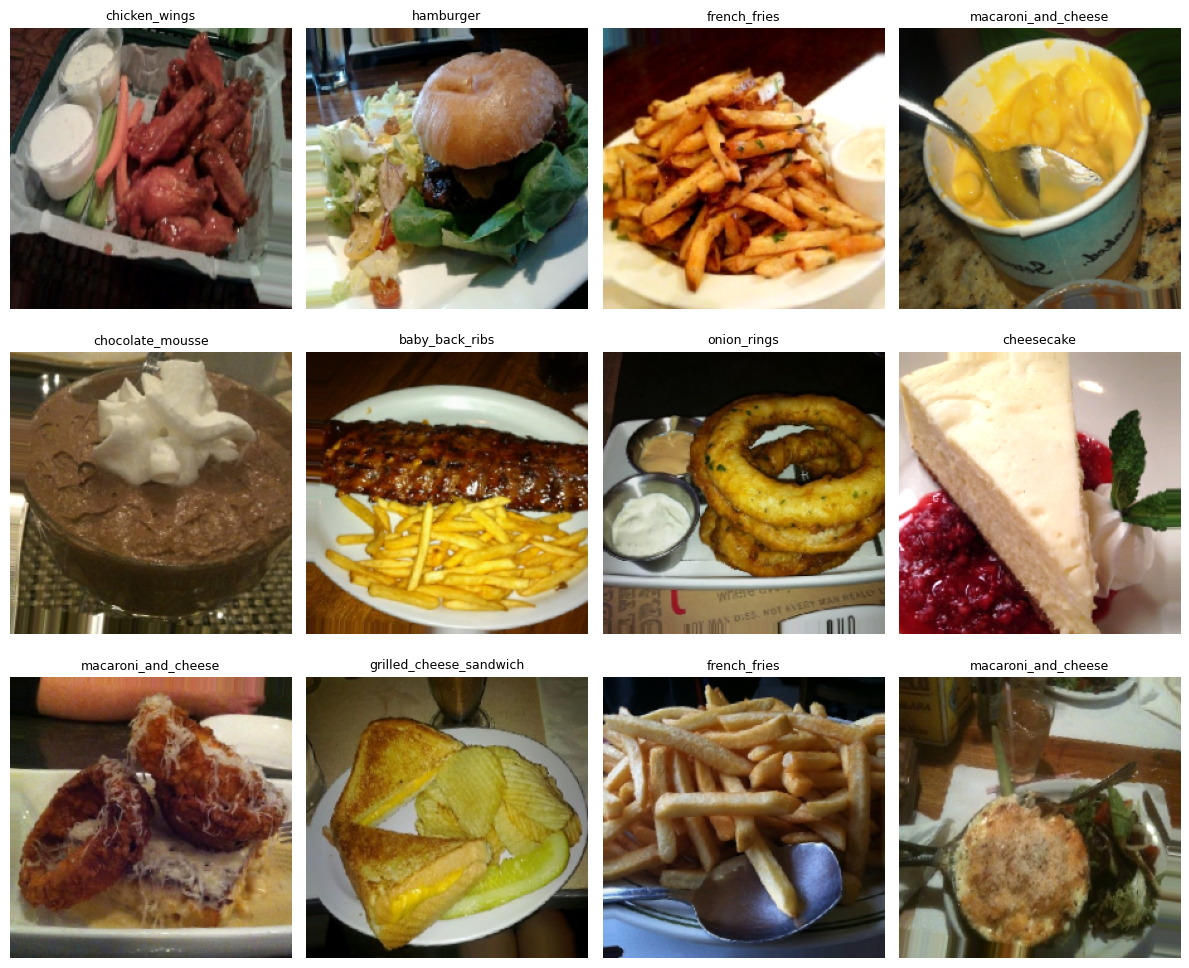

In [44]:
batch_x, batch_y = next(train_gen)
labels = {v: k for k, v in train_gen.class_indices.items()}

plt.figure(figsize=(12, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(batch_x[i])
    cls_idx = np.argmax(batch_y[i])
    plt.title(labels[cls_idx], fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

### Confidence threshold helper for inference

In [45]:
def top1_with_threshold(probs, idx_to_class, threshold=0.5):
    top_idx = int(np.argmax(probs))
    conf = float(probs[top_idx])
    if conf < threshold:
        return {"label": "Not an American food — outside scope", "confidence": conf}
    return {"label": idx_to_class[top_idx], "confidence": conf}

### Baseline CNN architecture (from scratch)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
)

def build_baseline_cnn(input_shape=(224, 224, 3), n_classes=25):
    model = Sequential([
        # Block 1
        Conv2D(64, (3,3), padding="same", activation="relu", input_shape=input_shape),
        BatchNormalization(momentum=0.8),
        Conv2D(64, (3,3), padding="same", activation="relu"),
        BatchNormalization(momentum=0.8),
        MaxPooling2D(),

        # Block 2
        Conv2D(128, (3,3), padding="same", activation="relu"),
        BatchNormalization(momentum=0.8),
        Conv2D(128, (3,3), padding="same", activation="relu"),
        Dropout(0.3),
        BatchNormalization(momentum=0.8),
        MaxPooling2D(),

        # Block 3
        Conv2D(256, (3,3), padding="same", activation="relu"),
        BatchNormalization(momentum=0.8),
        Conv2D(256, (3,3), padding="same", activation="relu"),
        BatchNormalization(momentum=0.8),
        MaxPooling2D(),
        Dropout(0.4),

        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(n_classes, activation="softmax"),
    ])
    return model


### Multi-GPU strategy and mixed-precision setup

In [47]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers.experimental import AdamW


# mixed_precision.set_global_policy("mixed_float16")

# Multi-GPU strategy
# strategy = tf.distribute.MirroredStrategy()
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
print("GPUs detected:", tf.config.list_logical_devices("GPU"))

LR = 1e-3
EPOCHS = 10

with strategy.scope():
    model = build_baseline_cnn(input_shape=(224, 224, 3), n_classes=len(classes))
    optimizer = AdamW(learning_rate=LR, weight_decay=1e-4)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
        metrics=["accuracy"],
    )

model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


GPUs detected: [LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_18 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_19 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 64)     0  

### Convert generators to tf.data pipelines for faster throughput

In [48]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    OUT_DIR / "train",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",
).shuffle(512).cache().prefetch(2)

val_ds = tf.keras.utils.image_dataset_from_directory(
    OUT_DIR / "val",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",
).cache().prefetch(1)


Found 17500 files belonging to 25 classes.
Found 3750 files belonging to 25 classes.


In [49]:
from tensorflow.keras import layers
aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])
train_ds = train_ds.map(lambda x, y: (aug(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)


### Training and checkpointing

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
from tensorflow.keras.callbacks import LearningRateScheduler

def exp_decay(epoch, lr):
    initial_lr = 3e-4
    k = 0.05  # decay rate
    return initial_lr * np.exp(-k * epoch)


# Early stopping and checkpointing for reproducibility
callbacks = [
    EarlyStopping(
        monitor="val_accuracy", 
        patience=10, 
        restore_best_weights=True, 
        verbose=1
        ),
    ModelCheckpoint(
        "baseline_cnn_best.keras", 
        monitor="val_accuracy", 
        save_best_only=True, 
        verbose=1
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.5, 
        patience=3, 
        min_lr=1e-6, 
        verbose=1
        ),
    # LearningRateScheduler(
    #     exp_decay, 
    #     verbose=1
    #     )
]

def warmup(epoch):
    if epoch < 3: 
        return 1e-3 * (epoch + 1) / 3   # ramp up to 1e-3
    return 1e-3

callbacks.append(tf.keras.callbacks.LearningRateScheduler(warmup))


print("Number of batches per epoch:", len(train_ds))
print("Example batch shape:", next(iter(train_ds))[0].shape)


# Train the model using tf.data pipelines
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

pd.DataFrame({
    "epoch": range(len(history.history["accuracy"])),
    "lr": [float(model.optimizer.learning_rate.numpy()) for _ in range(len(history.history["accuracy"]))],
    "train_acc": history.history["accuracy"],
    "val_acc": history.history["val_accuracy"],
    "train_loss": history.history["loss"],
    "val_loss": history.history["val_loss"],
}).to_csv("baseline_lr_tracking.csv", index=False)

# Save learning history for documentation and plotting
pd.DataFrame(history.history).to_csv("baseline_history.csv", index=False)

# Log final results
best_val = max(history.history["val_accuracy"])
print(f"Training complete. Best validation accuracy: {best_val:.3f}")


Number of batches per epoch: 547
Example batch shape: (32, 224, 224, 3)
Epoch 1/10
142/547 [======>.......................] - ETA: 1:04 - loss: 8.7796 - accuracy: 0.0465

### Evaluation on test set

118/118 [==============================] - 5s 28ms/step - loss: 3.2189 - accuracy: 0.0400
Test Accuracy: 4.00%
118/118 [==============================] - 6s 38ms/step


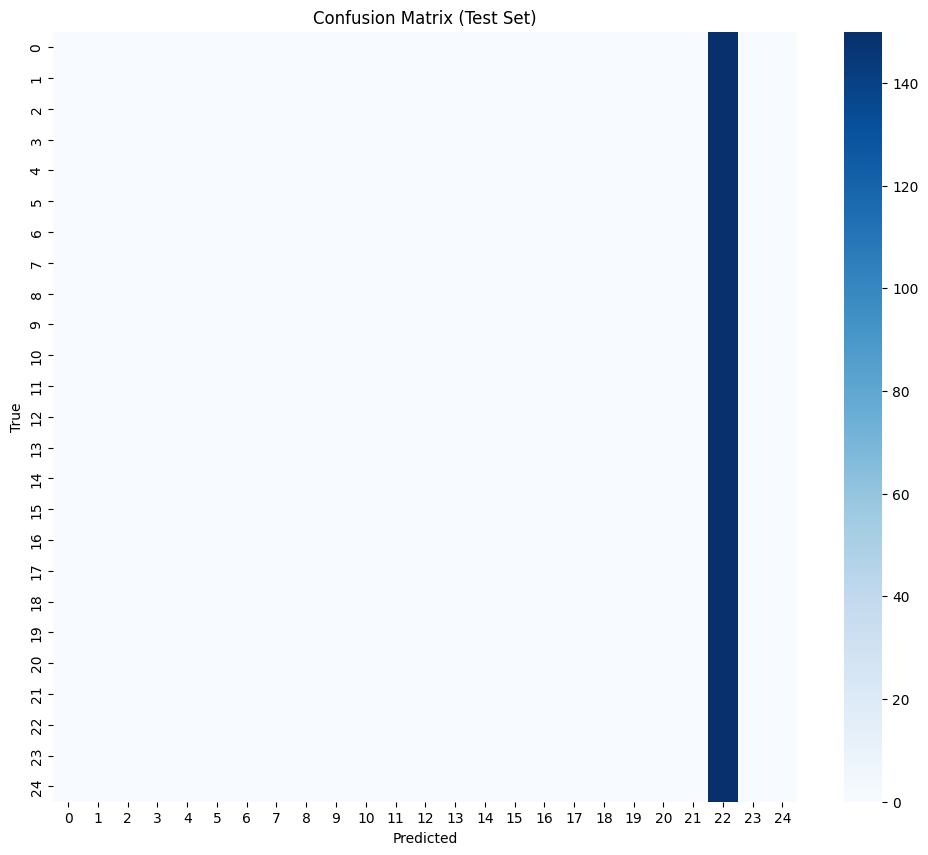

                         precision    recall  f1-score   support

         baby_back_ribs       0.00      0.00      0.00       150
             cheesecake       0.00      0.00      0.00       150
          chicken_wings       0.00      0.00      0.00       150
       chocolate_mousse       0.00      0.00      0.00       150
                churros       0.00      0.00      0.00       150
          club_sandwich       0.00      0.00      0.00       150
                 donuts       0.00      0.00      0.00       150
           french_fries       0.00      0.00      0.00       150
            greek_salad       0.00      0.00      0.00       150
grilled_cheese_sandwich       0.00      0.00      0.00       150
              hamburger       0.00      0.00      0.00       150
                hot_dog       0.00      0.00      0.00       150
              ice_cream       0.00      0.00      0.00       150
  lobster_roll_sandwich       0.00      0.00      0.00       150
    macaroni_and_cheese 

/home/har5ha/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/har5ha/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/har5ha/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

Text(0.5, 1.0, 'Training vs Validation Loss')

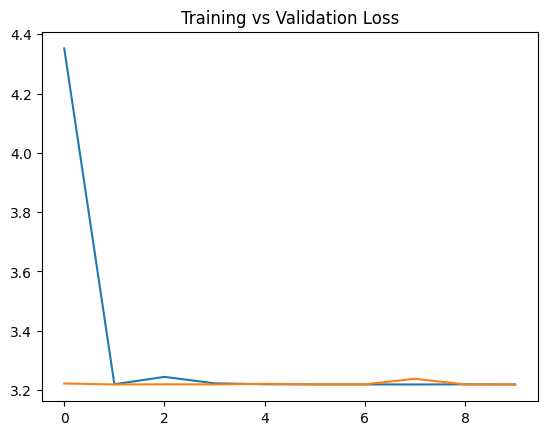

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training vs Validation Loss")


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, 'grilled_cheese_sandwich'),
  Text(1, 0, 'lobster_roll_sandwich'),
  Text(2, 0, 'pizza'),
  Text(3, 0, 'churros'),
  Text(4, 0, 'prime_rib'),
  Text(5, 0, 'pancakes'),
  Text(6, 0, 'baby_back_ribs'),
  Text(7, 0, 'waffles'),
  Text(8, 0, 'macarons'),
  Text(9, 0, 'chocolate_mousse'),
  Text(10, 0, 'hamburger'),
  Text(11, 0, 'pork_chop'),
  Text(12, 0, 'french_fries'),
  Text(13, 0, 'steak'),
  Text(14, 0, 'chicken_wings'),
  Text(15, 0, 'macaroni_and_cheese'),
  Text(16, 0, 'donuts'),
  Text(17, 0, 'club_sandwich'),
  Text(18, 0, 'cheesecake'),
  Text(19, 0, 'hot_dog'),
  Text(20, 0, 'greek_salad'),
  Text(21, 0, 'onion_rings'),
  Text(22, 0, 'pulled_pork_sandwich'),
  Text(23, 0, 'ice_cream'),
  Text(24, 0, 'omelette')])

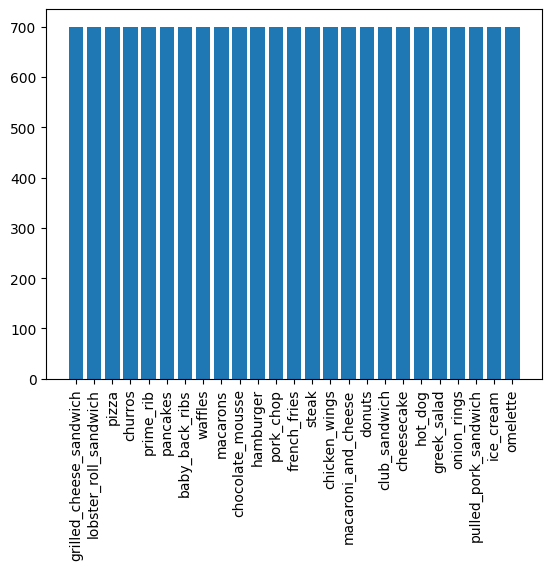

In [ ]:
import os
from collections import Counter
counts = Counter([p.parent.name for p in Path(OUT_DIR/'train').rglob("*.jpg")])
plt.bar(counts.keys(), counts.values()); plt.xticks(rotation=90)
